# Nanomotion dataset exploration

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat
import json
from scipy.stats import linregress, kurtosis, skew
from tqdm import tqdm

In [42]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.utilities.dataframe_functions import roll_time_series

In [43]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [44]:
from tkinter import filedialog
from tkinter import *

## Analysis functions, fitvar

In [8]:
def fitvar(y, x, n):
    
    N = len(y);
    count = 0
    i = 0
    chisq = np.empty(1+N//n, dtype='float64')
    
    while N-i > n:
        chunkY = np.float64(y[i+1:i+n])
        chunkX = np.float64(x[i+1:i+n])
        i = i + n
        
        yi = sum(chunkY)
        yq = sum(np.multiply(chunkY, chunkY))
        xy = sum(np.multiply(chunkX, chunkY))
    
        xi = sum(chunkX)
        xq = sum(np.multiply(chunkX, chunkX))
        denom = n*xq-xi*xi
        a = (n*xy-xi*yi)/denom
        b = (xq*yi-xi*xy)/denom
        chisq[count]=yq+a*a*xq+2*a*b*xi+n*b*b-2*a*xy-2*b*yi
        chisq[count]=chisq[count]/(n-1)
        count = count +1
        
    return chisq

def read_in_chunks(file_object, n=200000):

    while True:
        data = list(map(float, file_object))
        if not data:
            break
        yield data

def make_x(y):
    return range(0,len(y))

def open_files():
    
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)

    infiles = filedialog.askopenfilename(multiple=True)
    %gui tk
    return infiles

def process_files(n = 200000):
    
    f = []
    onevar = []
    variances = []
    
    filenames = open_files()
    for file in filenames:
        f = open(file)
        for chunk in read_in_chunks(f, n):
            onevar.append(fitvar(chunk, make_x(chunk), n))
        f.close()
        variances.append(np.concatenate(onevar))
        onevar = []
        
    return variances

def plot_vars(vars):
    toplimit = 0
    xlast = 0
    plt.figure(figsize=(16,8))
    for file in vars:
        tmp = np.percentile(file, 90)
        if toplimit < tmp:
            toplimit = tmp
        x = range(xlast, xlast+len(file))
        xlast += len(file)
        plt.plot(x, file);
        plt.ylim(0, 2.5*toplimit)

In [8]:
#vars = process_files()
#plot_vars(vars)

## Exploration

In [45]:
df_bact = pd.read_csv('data/BacteriaFiles.csv')
df_bact.head()

,FilePath,Bacteria,Drug,Code,Profile,FileMedia,FileDrug,DrugConc (mcrgpml),DrugDelay (min)
0,F:\D\Files\Prototype II\Bacteria\2015\CHUV\1se...,E. coli,Ceftriaxone,100,S,AlbBT.txt,Bceftriaxone2bBT.txt,2.0,32
1,F:\D\Files\Prototype II\Bacteria\2015\CHUV\1se...,E. coli,Ceftriaxone,200,S,AlbBT.txt,Bceftriaxone2bBT.txt,2.0,28
2,F:\D\Files\Prototype II\Bacteria\2015\CHUV\3se...,E. coli,Ceftriaxone,107,R,AlbBT.txt,Bceftriaxone2bBT1.txt,2.0,44
3,F:\D\Files\Prototype II\Bacteria\2015\CHUV\3se...,E. coli,Ceftriaxone,207,R,AlbBT.txt,Bceftriaxone2bBT1.txt,2.0,35
4,F:\D\Files\Prototype II\Bacteria\2015\CHUV\avg...,E. coli,Ciprofloxacin,101,R,AlbBT.txt,Bcip2concAnotherBT.txt,2.0,62


In [46]:
df_bact_profile = df_bact[['Code', 'Profile']]
df_bact_profile.columns = ['code', 'profile']
df_bact_profile.head()

,code,profile
0,100,S
1,200,S
2,107,R
3,207,R
4,101,R


In [7]:
with open('data/bactdataEx.json') as f:
    data = json.load(f)

In [8]:
my_index = pd.MultiIndex(levels=[[],[],[],[]],
                             labels=[[],[],[],[]],
                             names=[u'file',u'fWin', u'vWin', u'medium'])
df = pd.DataFrame(index=my_index, columns=['variance', 'waste'])
df

,,,,variance,waste
file,fWin,vWin,medium,,


In [9]:
for file in data:
    for fwin in data[file]:
        for vwin in data[file][fwin]:
            for medium in data[file][fwin][vwin]:
                df.loc[(file, fwin, vwin, medium),:] = [data[file][fwin][vwin][medium], 0]
df.drop('waste', axis=1, inplace=True)
df.head(10)

variance
file fWin vWin medium                                                   
c103 f20  v10  media   [0.00028802394304704176, 0.0022733928413443626...
               drug    [0.000535705546515839, 0.0007010582423440731, ...
          v100 media   [0.0007778647494320057, 0.0003176153099242994,...
               drug    [0.0007055918823339684, 0.00036956849779121463...
     f200 v10  media   [0.0002880239430470422, 0.0022733928413443353,...
               drug    [0.0005357055465158413, 0.0007010582423440702,...
          v100 media   [0.0007778647494320086, 0.0003176153099242998,...
               drug    [0.00070559188233397, 0.00036956849779121436, ...
c211 f20  v10  media   [0.0006620813777616297, 0.000270110058098789, ...
               drug    [0.0003206022142824237, 0.0004007756147070091,...

In [47]:
def remove_outliers(row):
    q25, q75 = np.percentile(row, 25), np.percentile(row, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    return [x for x in row if x > lower and x < upper]

def make_chunks(row):
    noChunks = 5
    chunkDown = 0
    varTime = []
    for i in range(1,noChunks+1):
        chunkUp = i*(len(row)//noChunks)
        varTime.append(np.median(row[chunkDown:chunkUp]))
        chunkDown = chunkUp
    return varTime

def make_features(row): 
    row_noo = remove_outliers(row)
    
    l1, l2,_,_,_ = linregress(range(0,len(row)), row)
    lo1, lo2,_,_,_ = linregress(range(0,len(row_noo)), row_noo)
    
    varChunks = make_chunks(row)
    varChunks_o = make_chunks(row_noo)
    
    return len(row), \
            np.mean(row),\
            np.median(row),\
            np.std(row),\
            kurtosis(row),\
            skew(row),\
            l1, l2,\
            varChunks,\
            row_noo, \
            len(row_noo),\
            np.mean(row_noo),\
            np.median(row_noo),\
            np.std(row_noo),\
            kurtosis(row_noo),\
            skew(row_noo),\
            lo1, lo2,\
            varChunks_o

In [11]:
df.index = pd.MultiIndex.from_tuples([(x[0].replace('c', ''), x[1].replace('f', ''), x[2].replace('v', ''), x[3]) for x in df.index])

In [12]:
df['duration'] = df.apply(lambda x: len(x['variance'])*int(x.name[2])/60, axis=1)

df['length'],\
df['mean'],\
df['median'],\
df['std'],\
df['kurtosis'],\
df['skew'],\
df['slope'],\
df['intercept'],\
df['varChunks'],\
df['variance_o'],\
df['length_o'],\
df['mean_o'],\
df['median_o'],\
df['std_o'],\
df['kurtosis_o'],\
df['skew_o'],\
df['slope_o'],\
df['intercept_o'],\
df['varChunks_o'] = zip(*df['variance'].apply(make_features))
df

variance  \
103 20  10  media  [0.00028802394304704176, 0.0022733928413443626...   
            drug   [0.000535705546515839, 0.0007010582423440731, ...   
        100 media  [0.0007778647494320057, 0.0003176153099242994,...   
            drug   [0.0007055918823339684, 0.00036956849779121463...   
    200 10  media  [0.0002880239430470422, 0.0022733928413443353,...   
            drug   [0.0005357055465158413, 0.0007010582423440702,...   
        100 media  [0.0007778647494320086, 0.0003176153099242998,...   
            drug   [0.00070559188233397, 0.00036956849779121436, ...   
211 20  10  media  [0.0006620813777616297, 0.000270110058098789, ...   
            drug   [0.0003206022142824237, 0.0004007756147070091,...   
        100 media  [0.00034222865333365186, 0.0003431207310229537...   
            drug   [0.0050064105962423925, 0.00041653213055679324...   
    200 10  media  [0.0006620813777616247, 0.00027011005809878853...   
            drug   [0.00032060221428242234, 0.0004007756147070072...   
        100 media  [0.0003422286533336513, 0.0003431207310229532,...   
            drug   [0.0050064105962423925, 0.00041653213055679276...   
ABK 20  10  media  [2.8724708850257932e-05, 4.323119200796416e-05...   
            drug   [2.52613485344931e-05, 2.0289255301401796e-05,...   
        100 media  [0.00010230589835183124, 3.947771208111205e-05...   
            drug   [3.401426733114603e-05, 2.7908972979105187e-05...   
    200 10  media  [2.8724708850259087e-05, 4.3231192007966276e-0...   
            drug   [2.5261348534493043e-05, 2.0289255301401983e-0...   
        100 media  [0.000102305898351831, 3.9477712081112054e-05,...   
            drug   [3.401426733114602e-05, 2.7908972979105147e-05...   
P14 20  10  media  [4.936204367289767e-05, 5.63898975197987e-05, ...   
            drug   [0.0014799292135611244, 0.0005090778140670621,...   
        100 media  [6.749421183076627e-05, 0.00010167693585393248...   
            drug   [0.00041355341398491063, 9.986821305900349e-05...   
    200 10  media  [4.9362043672897194e-05, 5.6389897519798836e-0...   
            drug   [0.0014799292135611265, 0.0005090778140670587,...   
        100 media  [6.749421183076625e-05, 0.00010167693585393209...   
            drug   [0.0004135534139849101, 9.986821305900356e-05,...   
P09 20  10  media  [0.0001721200905588664, 0.0002732789798087301,...   
            drug   [4.458530606891023e-05, 8.709897719959212e-05,...   
        100 media  [0.0001006057081229414, 0.00012773910056775674...   
            drug   [4.683342756014637e-05, 4.773882037590869e-05,...   
    200 10  media  [0.00017212009055886588, 0.0002732789798087297...   
            drug   [4.458530606891062e-05, 8.709897719959036e-05,...   
        100 media  [0.00010060570812294153, 0.0001277391005677566...   
            drug   [4.683342756014633e-05, 4.773882037590883e-05,...   
CHS 20  10  media  [0.0005495386297404515, 0.0005133160939907951,...   
            drug   [0.0006103766419618043, 0.000740439761824657, ...   
        100 media  [0.0005392202763500024, 0.0005482931777316488,...   
            drug   [0.0010937211369536955, 0.011657248898079363, ...   
    200 10  media  [0.0005495386297404469, 0.0005133160939907919,...   
            drug   [0.0006103766419618194, 0.0007404397618246448,...   
        100 media  [0.0005392202763500022, 0.0005482931777316467,...   
            drug   [0.0010937211369536901, 0.011657248898079365, ...   

                    duration  length      mean    median       std  \
103 20  10  media  15.000000      90  0.000477  0.000300  0.000747   
            drug   30.000000     180  0.000466  0.000334  0.000692   
        100 media  15.000000       9  0.000482  0.000322  0.000316   
            drug   30.000000      18  0.000471  0.000400  0.000258   
    200 10  media  13.333333      80  0.000498  0.000301  0.000790   
            drug   30.000000     180  0.000466  0.000334  0.000692   
        100 media  13.333333       8  0.0

In [13]:
df_export = df.reset_index().rename(index=str, columns={"level_0": "code", "level_1": "fitWin", "level_2":"varWin", "level_3":"media"})
df_export

,code,fitWin,varWin,media,variance,duration,length,mean,median,std,...,variance_o,length_o,mean_o,median_o,std_o,kurtosis_o,skew_o,slope_o,intercept_o,varChunks_o
0,103,20,10,media,"[0.00028802394304704176, 0.0022733928413443626...",15.000000,90,0.000477,0.000300,0.000747,...,"[0.00028802394304704176, 0.0002963587431652053...",79,0.000310,0.000297,0.000036,1.286143,1.376395,8.640140e-08,0.000307,"(0.0002925881811333413, 0.0003063625509886217,..."
1,103,20,10,drug,"[0.000535705546515839, 0.0007010582423440731, ...",30.000000,180,0.000466,0.000334,0.000692,...,"[0.000535705546515839, 0.0003669732229375658, ...",158,0.000340,0.000323,0.000058,1.213909,1.308215,1.444619e-07,0.000329,"(0.00034374526292821735, 0.0002926264767898228..."
2,103,20,100,media,"[0.0007778647494320057, 0.0003176153099242994,...",15.000000,9,0.000482,0.000322,0.000316,...,"[0.0003176153099242994, 0.0003492966983172255,...",7,0.000326,0.000318,0.000025,-0.496299,0.905143,-1.030339e-06,0.000329,"(0.0003176153099242994, 0.0003492966983172255,..."
3,103,20,100,drug,"[0.0007055918823339684, 0.00036956849779121463...",30.000000,18,0.000471,0.000400,0.000258,...,"[0.00036956849779121463, 0.0003934829726171749...",16,0.000396,0.000382,0.000085,0.095281,0.867872,8.202554e-06,0.000334,"(0.00036956849779121463, 0.0003174891080699301..."
4,103,200,10,media,"[0.0002880239430470422, 0.0022733928413443353,...",13.333333,80,0.000498,0.000301,0.000790,...,"[0.0002880239430470422, 0.00029635874316520265...",69,0.000310,0.000297,0.000036,1.339184,1.396261,1.040907e-07,0.000306,"(0.00029258818113334187, 0.0002995967639380468..."
5,103,200,10,drug,"[0.0005357055465158413, 0.0007010582423440702,...",30.000000,180,0.000466,0.000334,0.000692,...,"[0.0005357055465158413, 0.00036697322293756493...",158,0.000340,0.000323,0.000058,1.213909,1.308215,1.444619e-07,0.000329,"(0.0003437452629282175, 0.0002926264767898256,..."
6,103,200,100,media,"[0.0007778647494320086, 0.0003176153099242998,...",13.333333,8,0.000503,0.000336,0.000329,...,"[0.0003176153099242998, 0.0003492966983172255,...",6,0.000328,0.000320,0.000027,-0.928606,0.681247,6.446488e-07,0.000326,"(0.0003176153099242998, 0.0003492966983172255,..."
7,103,200,100,drug,"[0.00070559188233397, 0.00036956849779121436, ...",30.000000,18,0.000471,0.000400,0.000258,...,"[0.00036956849779121436, 0.0003934829726171755...",16,0.000396,0.000382,0.000085,0.095281,0.867872,8.202554e-06,0.000334,"(0.00036956849779121436, 0.0003174891080699318..."
8,211,20,10,media,"[0.0006620813777616297, 0.000270110058098789, ...",29.000000,174,0.000360,0.000289,0.000284,...,"[0.000270110058098789, 0.00024512983542058104,...",160,0.000304,0.000287,0.000054,0.006747,1.020425,4.283205e-09,0.000304,"(0.00029287237924345685, 0.0002860483622356269..."
9,211,20,10,drug,"[0.0003206022142824237, 0.0004007756147070091,...",50.000000,300,0.000569,0.000256,0.002658,...,"[0.0003206022142824237, 0.0004007756147070091,...",254,0.000264,0.000250,0.000039,2.762078,1.787567,-1.298805e-07,0.000280,"(0.00026664642139876164, 0.0002512227306171479..."


In [39]:
df_export = df_export.merge(df_bact_profile, on='code')

In [40]:
df_export.to_json("data/testingJson.json", orient="records")

## Warning, this will create (overwrite) a json file No_Filt

In [48]:
with open('data/bactdata.json') as f:
    data = json.load(f)
my_index = pd.MultiIndex(levels=[[],[],[],[]],
                             labels=[[],[],[],[]],
                             names=[u'file',u'fWin', u'vWin', u'medium'])
df = pd.DataFrame(index=my_index, columns=['variance', 'waste'])
for file in data:
    for fwin in data[file]:
        for vwin in data[file][fwin]:
            for medium in data[file][fwin][vwin]:
                df.loc[(file, fwin, vwin, medium),:] = [data[file][fwin][vwin][medium], 0]
df.drop('waste', axis=1, inplace=True)
df.index = pd.MultiIndex.from_tuples([(x[0].replace('c', ''), x[1].replace('f', ''), x[2].replace('v', ''), x[3]) for x in df.index])
df['duration'] = df.apply(lambda x: len(x['variance'])*int(x.name[2])/60, axis=1)

df['length'],\
df['mean'],\
df['median'],\
df['std'],\
df['kurtosis'],\
df['skew'],\
df['slope'],\
df['intercept'],\
df['varChunks'],\
df['variance_o'],\
df['length_o'],\
df['mean_o'],\
df['median_o'],\
df['std_o'],\
df['kurtosis_o'],\
df['skew_o'],\
df['slope_o'],\
df['intercept_o'],\
df['varChunks_o'] = zip(*df['variance'].apply(make_features))
df_export = df.reset_index().rename(index=str, columns={"level_0": "code", "level_1": "fitWin", "level_2":"varWin", "level_3":"media"})
df_export = df_export.merge(df_bact_profile, on='code')
df_export.to_json("data/dfOutputNoFilt.json", orient="records")


/home/kinase/Programs/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


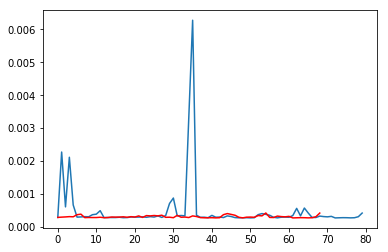

In [12]:
plt.plot(df.loc[('103','200', '10', 'media'), 'variance']);
plt.plot(df.loc[('103','200', '10', 'media'), 'no_outliers'], 'r');

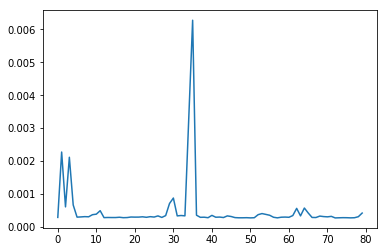

In [13]:
a = df.loc[('103','200', '10', 'media'), 'variance']
plt.plot(a);

### Tsafresh prediction

In [20]:
df_shift, y = make_forecasting_frame(a, kind="price", max_timeshift=10, rolling_direction=1)
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 16.52it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_tre

In [21]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-inf,value__value_count__value_0,value__value_count__value_1,value__value_count__value_inf,value__value_count__value_nan,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
1,8.295779e-08,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
2,5.251273e-06,0.001985,-1.000000,-1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,9.854224e-07,0.0
3,5.620752e-06,0.003651,-0.261252,-0.261252,0.513006,0.0,0.0,0.0,0.0,0.0,...,6.513766e-10,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,7.575573e-07,0.0
4,1.009434e-05,0.005158,-0.349852,-0.954769,0.858308,0.0,0.0,0.0,0.0,0.0,...,1.145429e-10,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,7.783120e-07,0.0
5,1.053718e-05,0.006608,-0.099535,-0.133665,0.785836,0.0,0.0,0.0,0.0,0.0,...,1.280829e-10,2.187536e-10,0.0,0.0,0.0,0.0,0.0,0.0,6.914248e-07,0.0


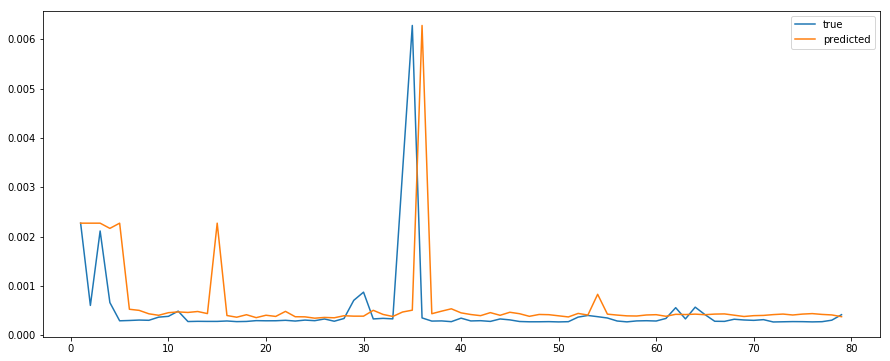

In [22]:
ada = AdaBoostRegressor()

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in range(1, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)
y_pred = pd.Series(data=y_pred, index=y.index)

plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

100%|██████████| 54/54 [00:02<00:00, 13.28it/s]


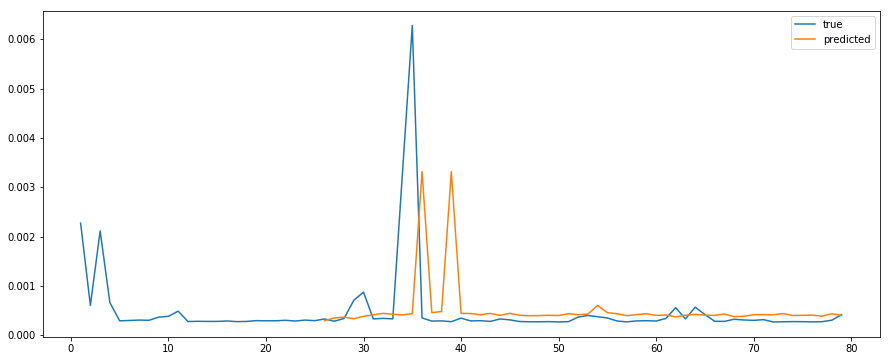

In [23]:
ada = AdaBoostRegressor()

y_pred = [np.NaN] * len(y)

for i in tqdm(range(25, len(y))):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)
y_pred = pd.Series(data=y_pred, index=y.index)

plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

In [24]:
importances = pd.Series(index=X.columns, data=ada.feature_importances_)
importances.sort_values(ascending=False).head(10)

variable
value__energy_ratio_by_chunks__num_segments_10__segment_focus_9      0.139989
value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0    0.103269
value__fft_aggregated__aggtype_"variance"                            0.096866
value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0    0.084971
value__fft_coefficient__coeff_5__attr_"real"                         0.080360
value__fft_aggregated__aggtype_"centroid"                            0.066483
value__fft_coefficient__coeff_4__attr_"imag"                         0.043229
value__energy_ratio_by_chunks__num_segments_10__segment_focus_5      0.042037
value__agg_linear_trend__f_agg_"min"__chunk_len_5__attr_"slope"      0.031550
value__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2    0.024411
dtype: float64

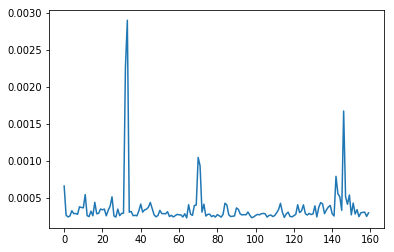

In [14]:
a = df.loc[('211','200', '10', 'media'), 'variance']
plt.plot(a);

In [26]:
df_shift, y = make_forecasting_frame(a, kind="price", max_timeshift=10, rolling_direction=1)
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, show_warnings=False)
ada = AdaBoostRegressor()

y_pred = [np.NaN] * len(y)

for i in tqdm(range(50, len(y))):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].values.reshape((1, -1)))
    
y_pred = pd.Series(data=y_pred, index=y.index)
y_pred = pd.Series(data=y_pred, index=y.index)

Feature Extraction: 100%|██████████| 20/20 [00:02<00:00,  6.64it/s]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_tre

100%|██████████| 109/109 [00:09<00:00,  7.45it/s]


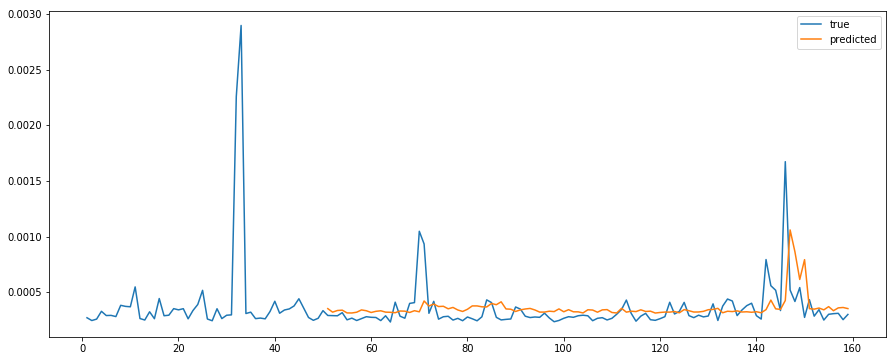

In [27]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()

### ARIMA prediction

/home/kinase/Programs/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


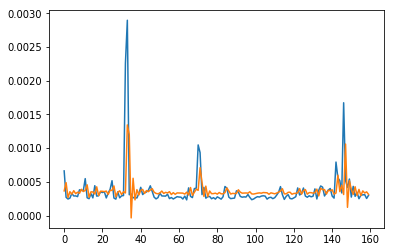

In [15]:
model = ARIMA(a, order=(2, 0, 2))  #ARMA
a_fit = model.fit()
plt.plot(a)
plt.plot(a_fit.fittedvalues);

### SARIMA prediction

/home/kinase/Programs/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kinase/Programs/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


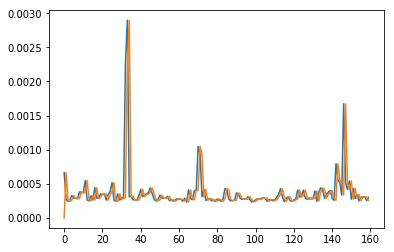

In [78]:
fit1 = sm.tsa.statespace.SARIMAX(a, order=(0,1,0)).fit()
a_fit = fit1.predict(start=50, end=155, dynamic=True)
plt.plot(a)
plt.plot(fit1.fittedvalues);

In [79]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1053.664
Date:                Sat, 22 Dec 2018   AIC                          -2105.329
Time:                        22:00:35   BIC                          -2102.260
Sample:                             0   HQIC                         -2104.083
                                - 160                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.02e-07   2.61e-09     39.045      0.000    9.69e-08    1.07e-07
===================================================================================
Ljung-Box (Q):                       39.18   Jarque-Bera (JB):              8616.97
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                            -1.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

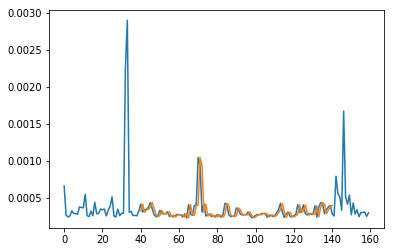

In [47]:
a_fit = fit1.predict(start=40, end=140)
plt.plot(a)
a_fit = np.insert(a_fit, obj=0, values=40*[np.nan])
plt.plot(a_fit);

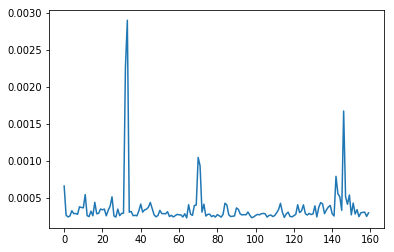

In [50]:
plt.plot(a);

/home/kinase/Programs/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/kinase/Programs/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


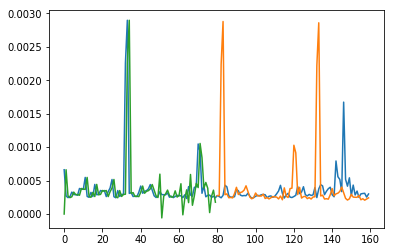

In [87]:
a1 = a[0:80]
fit1 = sm.tsa.statespace.SARIMAX(a1, order=(0,1,0), seasonal_order=(0,1,0,50)).fit()
a_fit = fit1.forecast(80)
a_fit = np.insert(a_fit, obj=0, values=80*[np.nan])

plt.plot(a)
plt.plot(a_fit);
plt.plot(fit1.fittedvalues);

<Figure size 432x288 with 0 Axes>

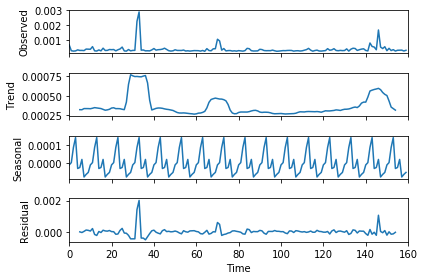

In [83]:
decomposition = sm.tsa.seasonal_decompose(a, freq=10)  
fig = plt.figure()  
fig = decomposition.plot()  

In [127]:
from math import sqrt
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def sarima_configs(a):
    data = a[:120]
    actual = a[120:]
    
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = [0, 5, 10]

    for p in p_params:
        for d in d_params:
            for q in q_params:
                for P in P_params:
                    for D in D_params:
                        for Q in Q_params:
                            for m in m_params:
                                fit = sm.tsa.statespace.SARIMAX(data, order=(p,d,q), seasonal_order=(P,D,Q,m)).fit()
                                a_fit = fit.forecast(40)
                                print(measure_rmse(actual, a_fit))

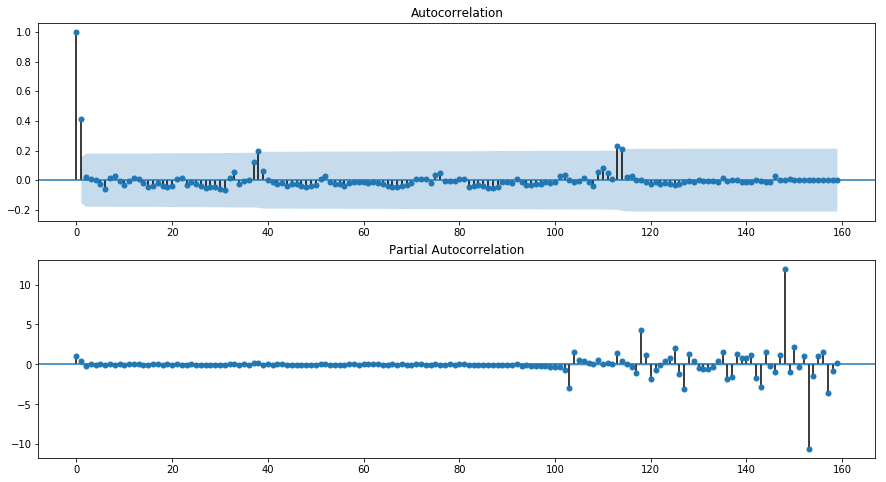

In [131]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
plt.figure(figsize=(15,8))
plt.subplot(211)
plot_acf(a, ax=plt.gca())
plt.subplot(212)
plot_pacf(a, ax=plt.gca())
plt.show()

In [139]:
import pmdarima as pm
data = a[0:120]
arima = pm.auto_arima(data, error_action='ignore', trace=1, seasonal=True)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-1631.724, BIC=-1614.999, Fit time=0.160 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-1592.488, BIC=-1586.913, Fit time=0.030 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=-1619.204, BIC=-1610.842, Fit time=0.028 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-1633.016, BIC=-1624.654, Fit time=0.059 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=-1628.489, BIC=-1617.339, Fit time=0.080 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-1631.748, BIC=-1620.598, Fit time=0.135 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=-1634.055, BIC=-1620.118, Fit time=0.206 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=-1631.567, BIC=-1614.842, Fit time=0.110 seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=-1629.783, BIC=-1610.271, Fit time=0.125 seconds
Total fit time: 0.9

In [149]:
data = a[0:80]
arima = pm.auto_arima(data,start_p=1, start_q=1, start_P=1, start_Q=1,
                  max_p=5, max_q=5, max_P=5, max_Q=5, seasonal=True,
                  stepwise=True, suppress_warnings=True, D=10, max_D=10,
                  error_action='ignore')

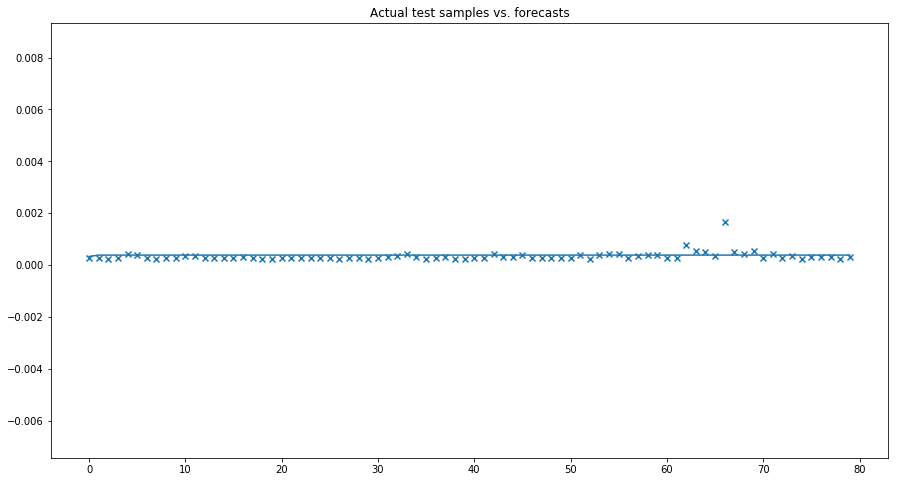

In [150]:
test = a[80:]
x = np.arange(len(test))
plt.figure(figsize=(15,8))
plt.scatter(x, test, marker='x')
plt.plot(x, arima.predict(n_periods=len(test)))
plt.title('Actual test samples vs. forecasts')
plt.show()